In [1]:
import torch
import scapy.all as scapy
import matplotlib.pyplot as plt

# consts
PCAP_PATH = "../../data/benign/weekday.pcap"
# PCAP_PATH = "../../data/huge/05-05-2021_weekday.pcap"
MAX_BITS_PORT = 16
MAX_BITS_SIZE = 11
PACKET_LENGTH = 264

In [2]:
from scapy.utils import PcapReader
packets = PcapReader(PCAP_PATH)
# for packet in packets:
#     print(packet.summary())

# print(packets.read_all(6)[0].summary())

In [3]:
# Read the pcap file
# packets = scapy.rdpcap(PCAP_PATH)

In [4]:
# def find_unique_layers(packets):
#     """
#     Find unique layers in the packet headers
#     """
#     unique_layers = []

#     for packet in packets:
#         if packet.haslayer(scapy.IP):
#             # Extract the layers from the packet
#             layers = packet.layers()

#             # Add the layer names to the set of unique layers
#             for layer in layers:
#                 unique_layers.append(layer.__name__)

#     return unique_layers

# # Find the unique layers in the packets
# unique_layers = set(find_unique_layers(packets))

# # Print the unique layers
# print("Unique Layers in the IPv4 Packets:")
# for layer in unique_layers:
#     print(layer)

In [10]:
import struct

def extract_bits_from_packets(packet, prev_packet):

    def extract_timestamp(packet):
        # Convert the integer part to binary
        integer_part = int(packet.time)
        binary_integer = bin(integer_part)[2:]

        # Convert the fractional part to binary
        fractional_part = packet.time - integer_part
        binary_fractional = bin(struct.unpack('!I', struct.pack('!f', fractional_part))[0])[2:]

        # Combine the integer and fractional binary parts
        timestamp_bits = binary_integer + binary_fractional
        if len(timestamp_bits) < 61:
            # print(len(timestamp_bits))
            diff = 61 - len(timestamp_bits)
            timestamp_bits = timestamp_bits + "0" * diff

        return timestamp_bits

    try:
        #### Extract timestamp ####
        # timestamp_bits = extract_timestamp(packet)

        current_time = float(packet.time)
        # print(type(current_time))
        prev_time    = float(prev_packet.time)
        # print(type(prev_time))
        diff         = current_time - prev_time
        # print(type(diff), diff)

        packed = struct.pack('f', diff)
        timestamp_bits = ''.join(f'{byte:08b}' for byte in packed)
        # print(len(timestamp_bits))

        #### Extract Src and Dst MAC Address ####
        if packet.haslayer(scapy.Ether):
            # Ethernet header
            src_mac = packet[scapy.Ether].src.split(":")
            src_mac_bits = ''.join(format(int(digit, 16), '08b') for digit in src_mac)
            dst_mac = packet[scapy.Ether].dst.split(":")
            dst_mac_bits = ''.join(format(int(digit, 16), '08b') for digit in dst_mac)
            mac_bits = src_mac_bits + dst_mac_bits
        else:
            mac_bits = "0" * 96

        #### Extract Src and Dst IP Address ####
        # IP and TCP header
        if packet.haslayer(scapy.IP):
            src_ip = packet[scapy.IP].src.split(".")
            src_ip_bits = ''.join(format(int(octet), '08b') for octet in src_ip)
            dst_ip = packet[scapy.IP].dst.split(".")
            dst_ip_bits = ''.join(format(int(octet), '08b') for octet in dst_ip)
            ip_bits = src_ip_bits + dst_ip_bits

            #### Extract Src and Dst Port ####
            sport = None
            dport = None
            if packet.haslayer(scapy.TCP):
                sport = packet[scapy.TCP].sport
                dport = packet[scapy.TCP].dport
            elif packet.haslayer(scapy.UDP):
                sport = packet[scapy.UDP].sport
                dport = packet[scapy.UDP].dport
            else:
                sport = 1055
                dport = 1055
            
            sport_bits = format(sport, f'0{MAX_BITS_PORT}b')
            dport_bits = format(dport, f'0{MAX_BITS_PORT}b')
            port_bits = sport_bits + dport_bits
        
            # ipip_bits = ip_bits + port_bits
            # print(len(ip_bits), len(port_bits))
            # print(ip_bits)
            # print(type(ip_bits))
        else:
            ip_bits = "0" * 64
            port_bits = "0" * 32

        #### Extract Packet Size ####
        packet_size = len(packet)
        packet_size_bits = format(packet_size, f'0{MAX_BITS_SIZE}b')

        #### Combine Each Bits ####
        packet_bits = timestamp_bits + mac_bits + ip_bits + port_bits + packet_size_bits
        # print(len(timestamp_bits), len(mac_bits), len(ip_bits), len(port_bits), len(packet_size_bits))
        packet_tensor = torch.tensor([int(bit) for bit in packet_bits])

    except Exception as e:
        print(e)
        # return None
    
    return packet_tensor

In [11]:
# def create_image(pcap_file):
#     """
#     Extract headers from the packets and convert them to bits
#     Headers includes:
#     1. Timestamp of the packet
#     2. Src and Dst MAC address
#     3. If IP layer is present:
#             Src and Dst IP address
#     4. If TCP layer is present:
#             Src and Dst port
#     5. Size of the packet
#     """
#     packets = scapy.rdpcap(pcap_file)

#     count = 0
#     packets_tensor = []
#     for packet in packets:

#         packet_tensor = extract_bits_from_packets(packet)

#         if packet_tensor is not None:
#             if count < PACKET_LENGTH:
#                 packets_tensor.append(packet_tensor)
#                 count = count + 1
#             else:
#                 packet_image = torch.vstack(packets_tensor)
#                 print(f"Size of Image: {packet_image.shape}")
#                 plt.imshow(packet_image, cmap="gray")
#                 plt.axis("off")
#                 plt.show()
#                 packets_tensor = []
#                 count = 0
#                 break

# if __name__ == "__main__":
#     create_image("../../data/benign/weekday.pcap")

In [12]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class PcapDataset(Dataset):
    def __init__(self, pcap_file, max_iterations, transform=None):
        self.packets = PcapReader(pcap_file)
        self.prev_packets = PcapReader(pcap_file)
        self.transform = transform
        self.max_iterations = max_iterations
    
    def __len__(self):
        if self.max_iterations is not None:
            return self.max_iterations
        else:
            raise NotImplementedError("Length of StreamingDataset is not defined.")
    
    def __getitem__(self, index):
        if index == 0:
            packet = next(self.packets)
            packet_tensor = extract_bits_from_packets(packet, packet)
        else:
            packet = next(self.packets)
            prev_packet = next(self.prev_packets)
            packet_tensor = extract_bits_from_packets(packet, prev_packet)

        # if packet_tensor is not None:
        if self.transform:
            packet_tensor = self.transform(packet_tensor)

        return packet_tensor


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the CNN Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Convolutional layer 1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Max pooling layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional layer 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Max pooling layer
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Deconvolutional layer 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  # Deconvolutional layer 2
            nn.Sigmoid()  # Sigmoid activation for output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
import sys

# Create an instance of the autoencoder
autoencoder = Autoencoder()

# Define loss function (Binary Cross-Entropy Loss for binary data)
criterion = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Define transformations (if needed)
transform = transforms.Compose([
    # Add any desired transformations here
])

In [14]:
batch_size = 8

best_loss = float('inf')
best_model_state = None

# Training loop
num_epochs = 5
print_interval = 100  # Print every 20000 packets

for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Create the dataset
    dataset = PcapDataset(pcap_file=PCAP_PATH, max_iterations=sys.maxsize, transform=transform)

    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=264 * batch_size, shuffle=False, drop_last=True)

    for i, packets in enumerate(dataloader):
        ...
#         reshaped_packets = packets.reshape(batch_size, 1, 264, 264).to(torch.float)
#         outputs = autoencoder(reshaped_packets)

#         # Compute the loss
#         loss = criterion(outputs, reshaped_packets)
        
#         # Backpropagation and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Print the loss and update the progress bar
#         if (i + 1) % print_interval == 0:
#             avg_loss = running_loss / print_interval
#             running_loss = 0.0
#             print(f"Epoch {(i+1)}/ {(epoch+1)} Average Loss: {avg_loss}")
    
#     # Calculate average loss for the epoch
#     avg_epoch_loss = running_loss / len(dataloader)
    
#     # Check if this is the best model so far
#     if avg_epoch_loss < best_loss:
#         best_loss = avg_epoch_loss
#         best_model_state = autoencoder.state_dict()

#     print(f"Epoch {epoch+1} Average Loss: {avg_loss}")
#     # Save the model checkpoint after every epoch
#     torch.save(autoencoder.state_dict(), f'autoencoder_model_epoch_{epoch+1}.pth')

# # Save the best trained model
# torch.save(best_model_state, 'autoencoder_model_best.pth')

# Training loop
# num_epochs = 30
# for epoch in range(num_epochs):
#     for packets in dataloader:
#         reshaped_packets = packets.reshape(batch_size, 1, 264, 264).to(torch.float)
#         outputs = autoencoder(reshaped_packets)
#         # break

#         # Compute the loss
#         loss = criterion(outputs, reshaped_packets)
        
#         # Backpropagation and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Print the loss for this epoch
#     # break
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Save the trained model
# torch.save(autoencoder.state_dict(), 'autoencoder_model_full.pth')

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
3

KeyboardInterrupt: 

In [19]:
# Load the trained autoencoder model
model = Autoencoder()
model.load_state_dict(torch.load('autoencoder_model_best.pth'))
model.eval()

batch_size = 1

# Create the DataLoader
dataset = PcapDataset(pcap_file=PCAP_PATH, max_iterations=sys.maxsize, transform=transform)
dataloader = DataLoader(dataset, batch_size=264 * batch_size, shuffle=False, drop_last=True)

reconstruction_errors = []

for packets in dataloader:
    reshaped_packets = packets.reshape(batch_size, 1, 264, 264).to(torch.float)
    outputs = model(reshaped_packets)

    # Compute the loss
    loss = criterion(outputs, reshaped_packets)
    reconstruction_errors.append(loss.data)

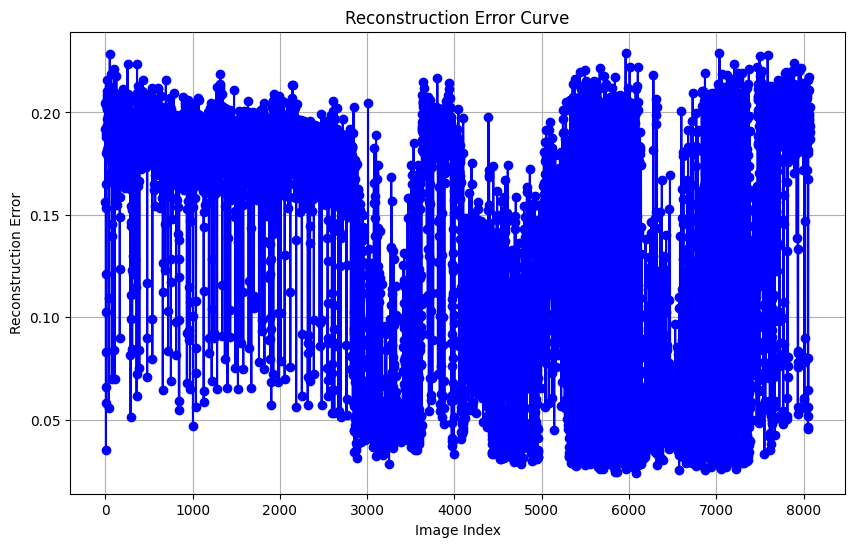

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x-axis values (image indices)
image_indices = np.arange(len(reconstruction_errors))

# Create a line curve (line plot)
plt.figure(figsize=(10, 6))
plt.plot(image_indices, reconstruction_errors, marker='o', linestyle='-', color='b')
plt.title('Reconstruction Error Curve')
plt.xlabel('Image Index')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Show or save the plot
plt.show()

In [68]:
def plot_re(pcap_path, dataset_name):
    # Load the trained autoencoder model
    model = Autoencoder()
    model.load_state_dict(torch.load('autoencoder_model_best.pth'))
    model.eval()

    batch_size = 1

    # Create the DataLoader
    dataset = PcapDataset(pcap_file=pcap_path, max_iterations=sys.maxsize, transform=transform)
    dataloader = DataLoader(dataset, batch_size=264 * batch_size, shuffle=False, drop_last=True)

    reconstruction_errors = []

    for packets in dataloader:
        reshaped_packets = packets.reshape(batch_size, 1, 264, 264).to(torch.float)
        outputs = model(reshaped_packets)

        # Compute the loss
        loss = criterion(outputs, reshaped_packets)
        reconstruction_errors.append(loss.data)
    
    # Generate x-axis values (image indices)
    image_indices = np.arange(len(reconstruction_errors))

    # Create a line curve (line plot)
    plt.figure(figsize=(10, 6))
    plt.plot(image_indices, reconstruction_errors, marker='o', linestyle='-', color='b')
    plt.title(f'Reconstruction Error Curve: {dataset_name}')
    plt.xlabel('Image Index')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)

    # Show or save the plot
    plt.show()

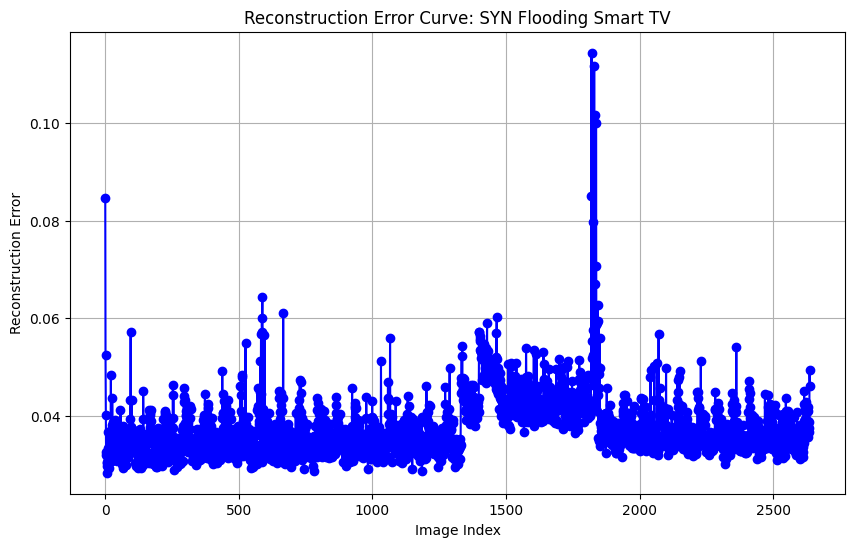

In [86]:
plot_re("../../data/SYN_Flooding_SmartTV.pcap", "SYN Flooding Smart TV")

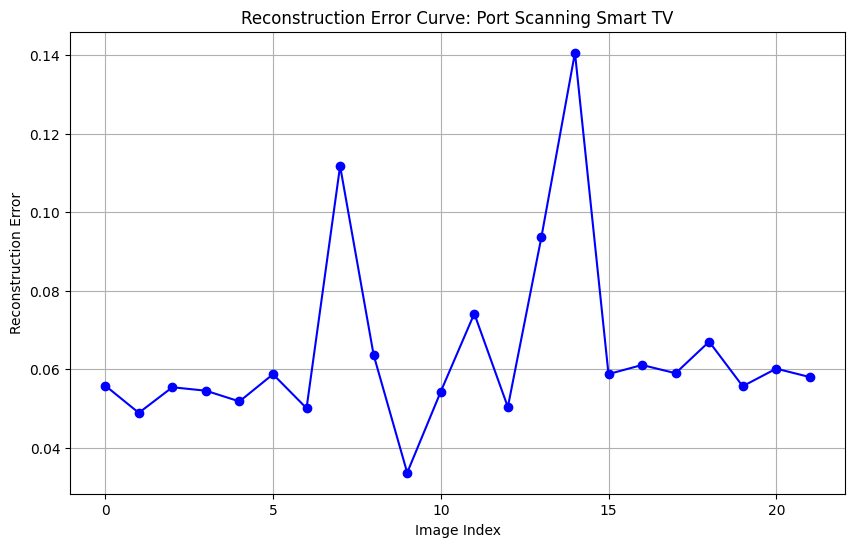

In [69]:
plot_re("../../data/Port_Scanning_SmartTV.pcap", "Port Scanning Smart TV")

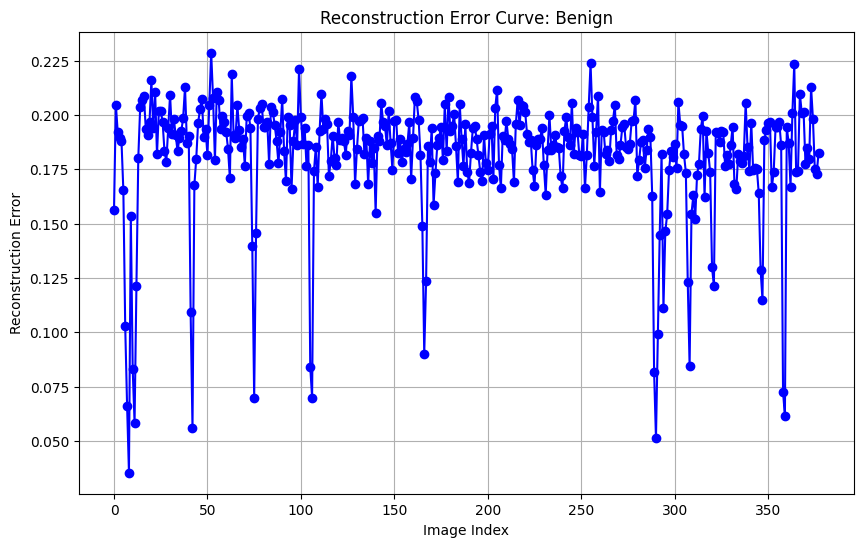

In [70]:
plot_re("../../data/weekday_100k.pcap", "Benign")

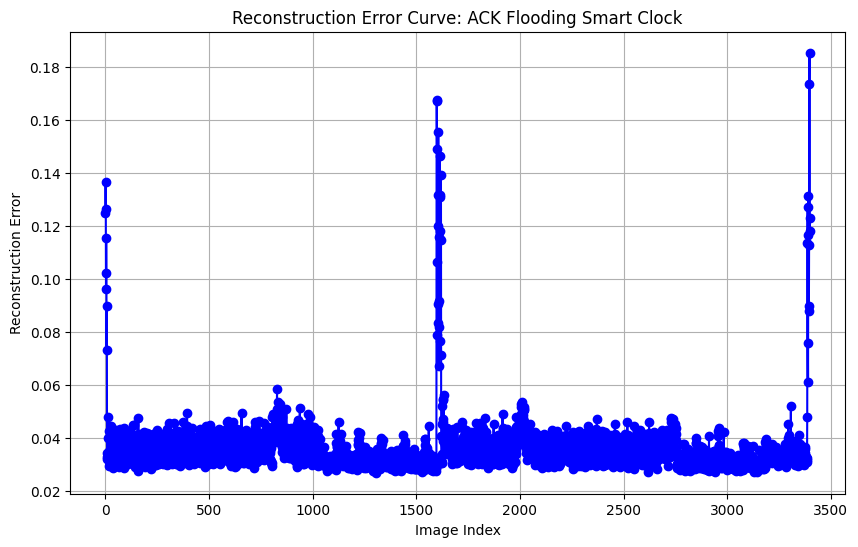

In [87]:
plot_re("../../data/ACK_Flooding_Smart_Clock_1.pcap", "ACK Flooding Smart Clock")

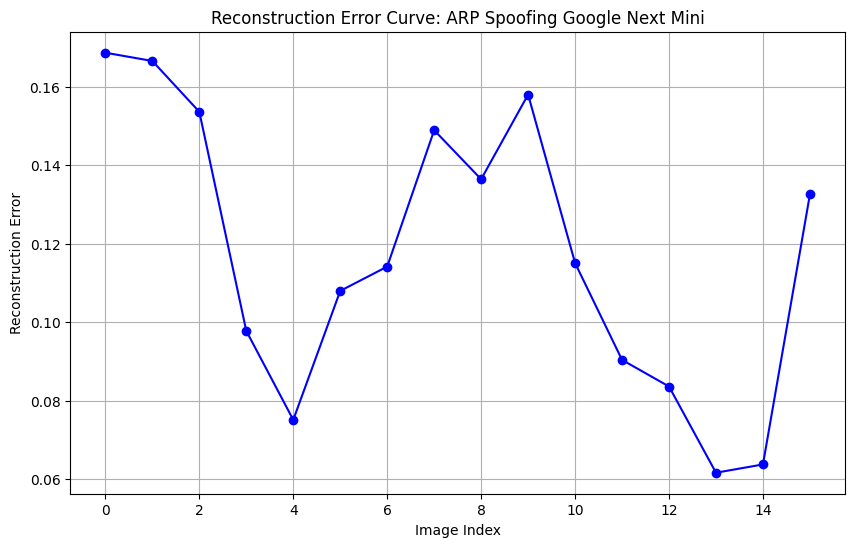

In [88]:
plot_re("../../data/ARP_Spoofing_Google-Nest-Mini_1.pcap", "ARP Spoofing Google Next Mini")

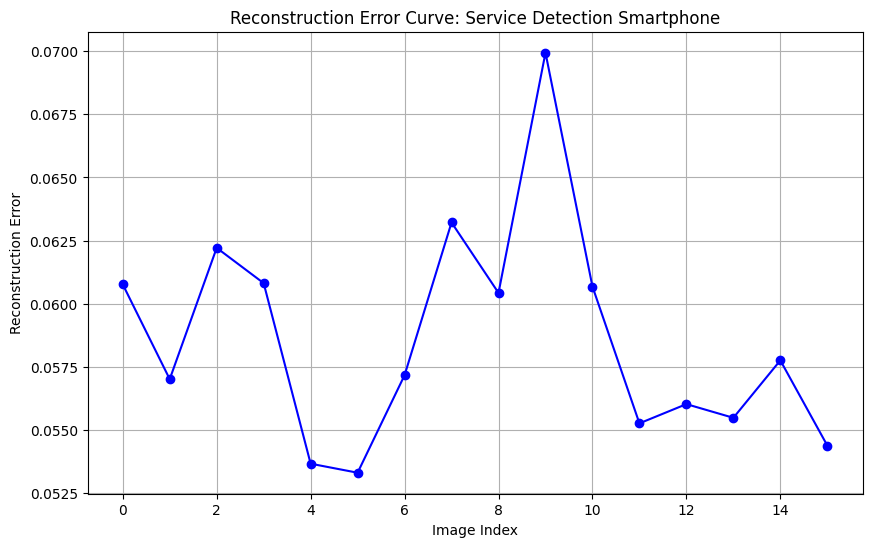

In [89]:
plot_re("../../data/Service_Detection_Smartphone_1.pcap", "Service Detection Smartphone")

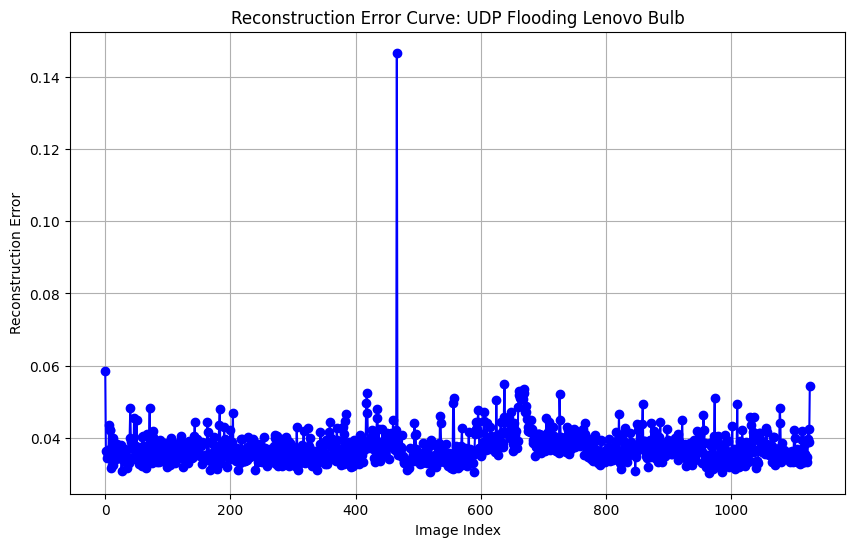

In [90]:
plot_re("../../data/UDP_Flooding_Lenovo_Bulb_1.pcap", "UDP Flooding Lenovo Bulb")

In [72]:
def plot_recon(pcap_path, dataset_name):
    # Load the trained autoencoder model
    model = Autoencoder()
    model.load_state_dict(torch.load('autoencoder_model_best.pth'))
    model.eval()

    batch_size = 1

    # Create the DataLoader
    dataset = PcapDataset(pcap_file=pcap_path, max_iterations=sys.maxsize, transform=transform)
    dataloader = DataLoader(dataset, batch_size=264 * batch_size, shuffle=False, drop_last=True)

    for packets in dataloader:
        reshaped_packets = packets.reshape(batch_size, 1, 264, 264).to(torch.float)
        outputs = model(reshaped_packets)

        # Convert tensors to numpy arrays for plotting
        original_image = reshaped_packets[0].squeeze().cpu().numpy()
        reconstructed_image = outputs[0].squeeze().detach().cpu().numpy()

        # Create subplots for original and reconstructed images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(dataset_name, fontsize=14)
        axes[0].set_title('Original Image')
        axes[0].imshow(original_image, cmap='gray')
        axes[0].axis('off')

        axes[1].set_title('Reconstructed Image')
        axes[1].imshow(reconstructed_image, cmap='gray')
        axes[1].axis('off')

        # Show the images side by side
        plt.tight_layout()
        plt.show()
        break

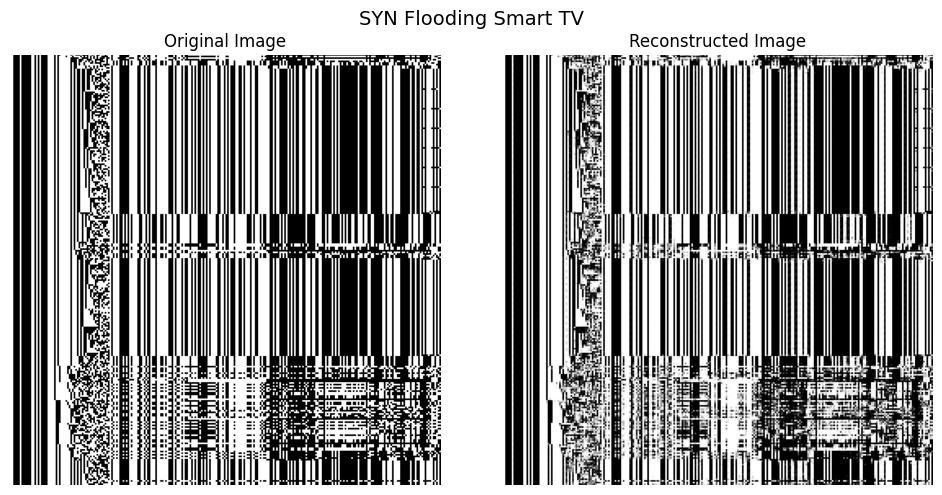

In [93]:
plot_recon("../../data/weekday_100k.pcap", "Benign")
# plot_recon("../../data/Port_Scanning_SmartTV.pcap", "Port Scanning Smart TV")
# plot_recon("../../data/SYN_Flooding_SmartTV.pcap", "SYN Flooding Smart TV")

In [2]:
# Print packet details
for packet in packets:
    print(packet.summary())
    break

# Perform basic analysis and statistics
total_packets = len(packets)
total_layers = len(set([packet.name for packet in packets]))
total_src_ips = len(set([packet[IP].src for packet in packets if IP in packet]))
total_dst_ips = len(set([packet[IP].dst for packet in packets if IP in packet]))

# Print statistics
print("Total Packets:", total_packets)
print("Total Unique Layers:", total_layers)
print("Total Source IPs:", total_src_ips)
print("Total Destination IPs:", total_dst_ips)


Ether / IP / TCP 192.168.0.121:34512 > 142.250.66.195:https A
Total Packets: 20000
Total Unique Layers: 1
Total Source IPs: 502
Total Destination IPs: 246


Highest Number of Bits in a Packet: 11999


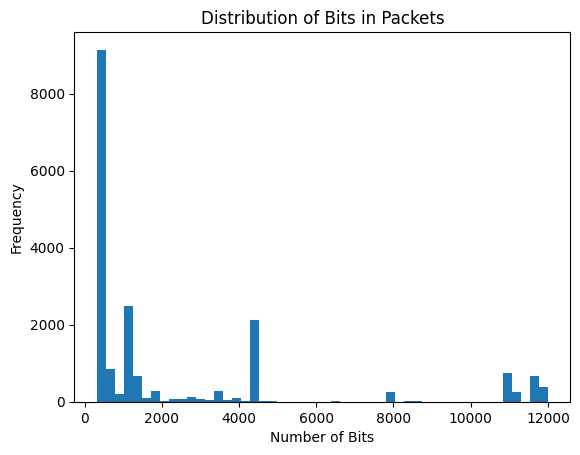

In [7]:
# Initialize the maximum number of bits
max_bits = 0

# Initialize a list to store the number of bits per packet
bits_per_packet = []

# Process each packet
for packet in packets:
    # print(packet.show())
    # break
    if "IP" in packet:
        # Extract the "IP" header
        ip_header = packet["IP"]

        # Convert the IP header to bits
        ip_header_bits = bin(int.from_bytes(bytes(ip_header), byteorder='big'))[2:]

        # Calculate the number of bits in the IP header
        num_bits = len(ip_header_bits)

        # Append the number of bits to the list
        bits_per_packet.append(num_bits)

    # Update the maximum number of bits if necessary
    if num_bits > max_bits:
        max_bits = num_bits

# Print the highest number of bits in a packet
print("Highest Number of Bits in a Packet:", max_bits)

# Plot the histogram
plt.hist(bits_per_packet, bins='auto')
plt.xlabel('Number of Bits')
plt.ylabel('Frequency')
plt.title('Distribution of Bits in Packets')
plt.show()

In [15]:
from scapy.all import rdpcap, wrpcap

# Path to the original pcap file
input_file = "../../data/huge/05-05-2021_weekday.pcap"

# Path to the output pcap file
output_file = "../../data/weekday_100k.pcap"

# Number of packets to extract
num_packets = 100000

# Read the original pcap file
packets = rdpcap(input_file)

# Take the first `num_packets` packets
filtered_packets = packets[:num_packets]

# Save the filtered packets to the output pcap file
wrpcap(output_file, filtered_packets)

In [6]:
import scapy.all as scapy

# Load the pcap file
pcap = scapy.rdpcap(PCAP_PATH)

initial_timestamp = 0
set_initial_timestamp = 0

# Iterate through the packets in the pcap file
for packet in pcap:

    # Get the timestamp of the packet
    timestamp = packet.time
    if not set_initial_timestamp:
        initial_timestamp = timestamp
        set_initial_timestamp = 1

    timestamp = timestamp - initial_timestamp
    if timestamp < 0.05:
        print(timestamp)
    else:
        print("Done!!!!")
        set_initial_timestamp = 0

    # Print the timestamp of the packet
    # print(timestamp)

0.000000
0.023026
0.023204
0.024978
0.037531
0.037665
Done!!!!
0.000000
0.004089
0.004885
0.022380
0.032779
Done!!!!
0.000000
0.007249
0.011938
0.017803
0.040320
Done!!!!
0.000000
0.000376
0.012963
Done!!!!
0.000000
0.030367
0.032125
0.032401
Done!!!!
0.000000
0.007321
0.028038
0.045216
Done!!!!
0.000000
0.010548
0.010640
0.011058
0.011946
0.028283
0.028308
Done!!!!
0.000000
0.000004
0.018509
0.018533
0.020339
0.020579
0.020940
0.021050
0.021070
Done!!!!
0.000000
0.000019
0.003368
0.022284
0.023692
0.032369
0.033058
0.048999
0.049257
0.049507
Done!!!!
0.000000
0.001433
0.001470
0.006113
0.007071
0.018204
0.023507
Done!!!!
0.000000
Done!!!!
0.000000
0.001311
0.043174
Done!!!!
0.000000
0.043591
0.043685
0.043710
0.045879
Done!!!!
0.000000
0.007034
0.007977
0.045057
0.045094
0.046646
0.046922
0.046941
0.047239
0.047338
0.047356
Done!!!!
0.000000
0.002520
0.003769
0.003820
0.003843
0.005471
0.005516
0.005538
0.005559
0.020990
0.026950
0.045289
Done!!!!
0.000000
0.002621
0.029628
0.029842
0

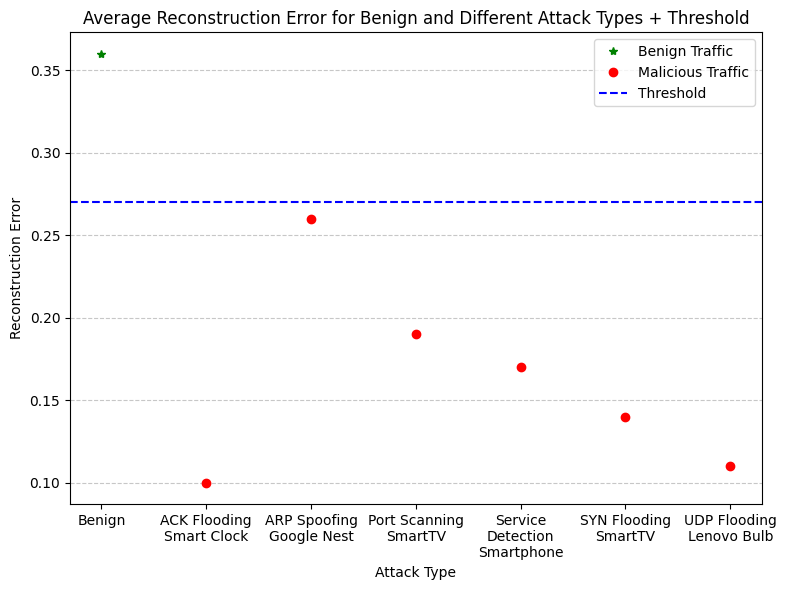

In [15]:
import matplotlib.pyplot as plt

# Data
threshold = 0.27
labels = ["Benign", "ACK Flooding\nSmart Clock", "ARP Spoofing\nGoogle Nest", 
          "Port Scanning\nSmartTV", "Service\nDetection\nSmartphone", "SYN Flooding\nSmartTV",
          "UDP Flooding\nLenovo Bulb"]
reconstruction_errors = [0.36, 0.10, 0.26, 0.19, 0.17, 0.14, 0.11]

# Separate the data points
first_two_labels = labels[:1]
first_two_errors = reconstruction_errors[:1]
rest_labels = labels[1:]
rest_errors = reconstruction_errors[1:]

# Create a point plot
plt.figure(figsize=(8, 6))
plt.plot(first_two_labels, first_two_errors, marker='*', color='green', linestyle='', label='Benign Traffic')
plt.plot(rest_labels, rest_errors, marker='o', color='red', linestyle='', label='Malicious Traffic')
plt.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
plt.xticks(range(len(labels)), labels, rotation=0)  # Rotate x-axis labels for better visibility
plt.ylabel('Reconstruction Error')
plt.xlabel('Attack Type')
plt.title('Average Reconstruction Error for Benign and Different Attack Types + Threshold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()